In [1]:
import matplotlib.pyplot as plt
import matplotlib
from typing import Tuple
from functools import cache
import itertools
import scipy.special
import scipy.stats
import numpy as np
import libarti_prob

%matplotlib inline
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (16,9)
matplotlib.rcParams['savefig.bbox'] = 'tight'

# An implementation of artifact statistics
This code aims to demonstrate the ideas and maths shown in the following paper: [https://www.overleaf.com/read/nvxmkdpqjprj](https://www.overleaf.com/read/nvxmkdpqjprj)

I offer three contributions:

1. Very fast implementation of GenshinOptimizer's existing Roll Probability Calculator. frzyc noted that it's somewhat straining the front-end, so I've made a cache-based implementation that runs in microseconds per query.
2. A method that, given an optimization target and a current build, finds the artifact in the inventory that has the greatest chance of improving your build.
3. A method to evaluate any particular build by scoring how difficult it would be to improve any item of the build.

## Type 1 Query (Contribution 1)
The type 1 query behaves as:
$$ P(A_1\geq a_1 \land A_2\geq a_2\land\cdots)$$

This is already implemented in frzyc's GenshinOptimizer, but issues regarding its computational load have been brought up. The following method I present is quite fast; with appropriate caching it reaches about 50µs per loop on my laptop. (around .05s for 1,000 queries)

Also, this solution is exact.

In [2]:
sigma = libarti_prob.sigma
mu = libarti_prob.mu

# P(A1 >= a1 AND A2 >= a2)
def prob1(a, N=5, b=1):
    a = sorted(a, reverse=True)
    ret = 0
    for j1 in reversed(range(N+1)):
        m1 = mu(a[0], j1+b)
        if m1 == 0: break
        if len(a) == 1:
            ret += sigma([j1], n=N) * m1
            continue
        for j2 in reversed(range(N+1-j1)):
            m2 = mu(a[1], j2+b)
            if m2 == 0: break
            if len(a) == 2:
                ret += sigma([j1, j2], n=N) * m1*m2
                continue
            for j3 in reversed(range(N+1-j1-j2)):
                m3 = mu(a[2], j3+b)
                if m3 == 0: break
                j4 = N-j1-j2-j3
                mm = m1*m2*m3
                if len(a) == 4: mm *= mu(a[3], j4+b)
                ret += sigma([j1, j2, j3, j4], n=N) * mm
    return ret

In [4]:
# %timeit prob1([26,13,10,10])

### Type 1 Query on existing artifact
Existing artifacts reduce to a special case of the previous query. Since they're practically the same query, the runtime is essentially the same, and is faster if `rolls_left` is smaller.

In [5]:
def p1_existing(requirements, existing, rolls_left):
    transformed_requirements = []
    for ai, az in zip(requirements, existing):
        transformed_requirements.append(ai - az)
    
    return prob1(transformed_requirements, N=rolls_left, b=0)

## Type 2 Query
The type 2 query behaves as:
$$ P(k_1A_1 + k_2A_2 + \cdots\geq d^*)$$

It will be useful later down the line.

In [6]:
# thr-  threshold value (d*)
# ks -  weight values
# N  -  num rolls
# b  -  number of guaranteed rolls for each substat
# E  -  returns E[d | d > d*]
def prob2(thr, ks, N=5, b=1, fast=True, exact=False, E=False):
    if not fast:
        return prob2_slow(thr, ks, N, b, exact=exact, E=E)
    
    ks = np.array(ks)
    n4b = N + 4*b
    mu = 17/8*n4b * np.sum(ks)
    var = (5/16*n4b + N*289/16)*np.sum(ks**2) - N*(17/8*np.sum(ks))**2
    if np.isclose(var, 0):
        if mu > thr:
            if E: return np.array([1, mu - thr])
            return 1
        if E: return np.array([0, 0])
        return 0
    
    p = scipy.special.erfc((thr - mu) / np.sqrt(2 * var)) / 2
    if E:
        if np.isclose(p, 0): return np.array([p, 0])
        phi = np.exp(-(thr-mu)**2 /var/2)/np.sqrt(2*np.pi)
        return np.array([p, mu + np.sqrt(var) * phi / p - thr])
    return p

@cache
def nk3(n, k):
    return sum([scipy.special.binom(n, i) * scipy.special.binom(n, k-2*i) for i in range(k//2+1)])

def exact_vs(ks, js):
    if len(ks) == 0:
        return np.array([[0, 1]])
    
    k, j = ks[-1], js[-1]
    pr1 = np.array([(k*i, nk3(j, i-7*j) / 4**j) for i in range(7*j, 10*j+1)])
    pr2 = exact_vs(ks[:-1], js[:-1])
    
    res = {}
    for v1, p1 in pr1:
        for v2, p2 in pr2:
            res[v1 + v2] = res.get(v1+v2, 0) + p1*p2
    return np.array([(k, v) for k, v in res.items()])


def subsum(z):
    for i in range(z+1):
        for j in range(z-i+1):
            for k in range(z-i-j+1):
                yield (i, j, k, z-i-j-k)

def prob2_slow(thr, ks, N=5, b=1, exact=False, E=False):
    if E:
        raise NotImplemented()
    reps = 0
    ks = np.array(ks)
    
    ptot = 0
    if len(ks) == 4:
        it = subsum(N)
    else:
        it = filter(lambda x: sum(x) <= N, itertools.product(range(N+1), repeat=len(ks)))
    for js in it:
        js2 = np.array(js) + b
        mn = sigma(js, n=N)
        if mn == 0: continue
        
        if thr <= 7*np.sum(ks * js2):
            ptot += mn
            continue
        elif thr > 10*np.sum(ks * js2):
            continue

        if exact:
            ext = exact_vs(ks, js2)
            p_est = sum([p for v, p in ext if v > thr])
        else:
            mu = 8.5 * np.sum(ks * js2)
            var = 1.25 * np.sum(ks*ks * js2)
            p_est = scipy.special.erfc((thr - mu) / np.sqrt(2 * var)) / 2
        ptot += mn * p_est
    return ptot


In [7]:
print(f'Approx (fast) P(100EM or 15CR): {prob2(38.6, [.9, 1])}')
print(f'Approx (slow) P(100EM or 15CR): {prob2(38.6, [.9, 1], fast=False)}')
print(f'Exact         P(100EM or 15CR): {prob2(38.6, [.9, 1], fast=False, exact=True)}')

Approx (fast) P(100EM or 15CR): 0.4041975884216023
Approx (slow) P(100EM or 15CR): 0.425874154717938
Exact         P(100EM or 15CR): 0.415463924407959


In [8]:
prob2(50, [.77777,.77777,0,0], fast=False, exact=True)

0.00140380859375

### Timings
Here I've tested the timing of [Fast], [Slow], and [Exact]. [Fast] is blazing fast, but is prone to being inaccurate for certain combinations of weights. [Slow] is 10x slower, but has small error bounds that we can take advantage of. There is never a real reason to use the [Exact] solver because [Slow] will always be within 1-2% of the true value.

In [9]:
# %timeit prob2(38.6, [.9, 1])

In [10]:
# %timeit prob2(38.6, [.9, 1], fast=False)

In [11]:
# %timeit prob2(38.6, [.9, 1], fast=False, exact=True)

## Connection to the Damage Formula
The following couple blocks set up my damage evaluation schema, where I've manually filled in some standard(ish) values.

All the percent- values are multiplied by 1000 for some reason.

In [12]:
import artifact2
import damage2
import random
from util.common import statnames, statmap, slotnames

In [13]:
# Stats of lvl 90 Diona w/ protype crescent
diona_stats = np.zeros(len(statnames))
diona_stats[statmap['HP']] = 9570
diona_stats[statmap['BaseATK']] = 722
diona_stats[statmap['ATK%']] = 413
diona_stats[statmap['DEF']] = 601
diona_stats[statmap['CR']] = 50
diona_stats[statmap['CD']] = 500
diona_stats[statmap['ER']] = 1000
diona_stats[statmap['Cryo']] = 240

In [14]:
# The artifacts I have equipped
flower = np.zeros(len(statnames))
flower[statmap['HP']] = 4780
flower[statmap['ATK']] = 33
flower[statmap['DEF']] = 16
flower[statmap['EM']] = 82
flower[statmap['CD']] = 140

feather = np.zeros(len(statnames))
feather[statmap['ATK']] = 311
feather[statmap['ER']] = 162
feather[statmap['DEF']] = 37
feather[statmap['CR']] = 31
feather[statmap['CD']] = 192

sands = np.zeros(len(statnames))
sands[statmap['EM']] = 187
sands[statmap['HP']] = 538
sands[statmap['DEF']] = 39
sands[statmap['CR']] = 124
sands[statmap['CD']] = 78

cup = np.zeros(len(statnames))
cup[statmap['Cryo']] = 466
cup[statmap['HP%']] = 47
cup[statmap['ATK%']] = 111
cup[statmap['ER']] = 220
cup[statmap['EM']] = 16

hat = np.zeros(len(statnames))
hat[statmap['CR']] = 311
hat[statmap['HP']] = 299
hat[statmap['CD']] = 155
hat[statmap['ATK%']] = 105
hat[statmap['EM']] = 56

In [15]:
dmg = damage2.NormalDmg(2.23) * damage2.CritMult() * damage2.VapeMelt(1.5) * damage2.DmgBonus('Cryo')
stats = diona_stats + flower + feather + sands + cup + hat
print(f'Current damage per charged shot: {dmg.eval(stats)[0]}')

Current damage per charged shot: 20761.071160967404


## Queries for replacing an artifact (Contribution 2)
Let's say I have a couple candidate artifacts to upgrade. All of them are EM sands, and they are all at lvl 0.

In [16]:
def to_stat(subs):
    st = np.zeros(len(statnames))
    for k, v in subs.items():
        st[statmap[k]] = v * artifact2.sub_vals[k] / 10
    return st

# Finds linear approximation of 4x4 Hessian
def appx_hessian2(H, k=1):
    a = np.sum(H) + np.trace(H)
    b = np.sum(H, axis=0) + np.diag(H)
    
    lhs = np.zeros(5)
    lhs[1:] = k / 7 * (a + 2*b)
    lhs[0] = k / 6 * a
    
    rhs_inv = 1 + np.eye(5)
    rhs_inv[:,0] = -6
    rhs_inv[0,:] = -k
    rhs_inv[0,0] = 5*k
    gv = rhs_inv @ lhs
    return gv[0], gv[1:]

In [17]:
class QueryHandle:
    def __init__(self, char_stats, artis, dmg):
        self.dmg = dmg
        self.ch = char_stats
        self.a = artis
        
        self.slot = None
        self.a2 = None
        
        self.dmg0, _, _ = self.dmg.eval(sum(self.a, start=self.ch))
    
    def set_slot(self, slot, main):
        if isinstance(slot, str):
            slot = slotnames.index(slot)
        self.slot = slot
        self.a2 = np.zeros(len(statnames))
        self.a2[statmap[main]] = artifact2.main_vals[main]
        self.vgh = self.dmg.eval(self._stat())
        
    def _stat(self, slot=None, main=None):
        if slot is not None:
            self.set_slot(slot, main)

        ret = self.ch
        for i, a in enumerate(self.a):
            if i == self.slot:
                ret = ret + self.a2
                continue
            ret = ret + a
        return ret
    
    def _resolve_lpd(self, lpd, E=False):
        if E:
            ptot, dtot = 0, 0
            for l, (p, d) in lpd:
                ptot += l*p
                dtot += l*p*d
            if np.isclose(ptot, 0): return 0, 0
            return ptot, dtot/ptot
        return np.sum(np.prod(lpd, axis=1))

    def linearize(self, subs, rolls=5):
        if self.slot is None: raise RuntimeError('Need to specify a slot first!')
        ixs = [statmap[k] for k in subs]
        if np.all(to_stat(subs) == 0):
            v, g, h = self.vgh
        else:
            v, g, h = self.dmg.eval(self._stat() + to_stat(subs))

        ix_names = [statnames[s] for s in ixs]
        scale = np.array([artifact2.sub_vals[k]/10 for k in ix_names])

        gnorm = g[ixs] * scale
        hnorm = h[ixs][:,ixs] * np.outer(scale, scale)
        if len(ixs) == 3:
            # force the thing to be 4x4.
            gnorm = np.append(gnorm, 0)
            hnorm = np.pad(hnorm, [0,1])
            rolls = 4
        c0, h_lin = appx_hessian2(hnorm, k=10*rolls)
        return v + c0, gnorm + h_lin / 2
    
    def eval_arti(self, subs, rolls=0, fast=True, E=False):
        rolls_left = 5 - rolls
        if len(subs) == 3:
            rolls_left = 4

        c, m = self.linearize(subs, rolls_left)
        return prob2(self.dmg0 - c, m, N=rolls_left, b=0, fast=fast, E=E)
    
    def eval_sub(self, subs, p3sub=.8, fast=True, E=False):
        rolls_left = 5 + 4
        c, m = self.linearize(subs, rolls_left)
        
        lpd = []
        lpd.append([p3sub, prob2(self.dmg0 - c, m, N=4, b=1, fast=fast, E=E)])
        lpd.append([1-p3sub, prob2(self.dmg0 - c, m, N=5, b=1, fast=fast, E=E)])
        return self._resolve_lpd(lpd, E)
    
    def eval_slot(self, slot, p3sub=.8, fast=True, E=False):
        main_distr = artifact2.mainstat[slot].distr
        main_denom = sum(main_distr.values())
        lpd = []
        for main, v_main in main_distr.items():
            p_main = v_main / main_denom
            self.set_slot(slot, main)
            
            sub_distr = artifact2.substat
            sub_distr = sub_distr.remove(main)
            for c in itertools.combinations(sub_distr.k, 4):
                prb = p_main * libarti_prob.p_subs(c, main)
                c2 = {cc: 0 for cc in c}
                lpd.append([prb, self.eval_sub(c2, p3sub=p3sub, fast=fast, E=E)])
        return self._resolve_lpd(lpd, E)

    def dmg_per_arti(self, p3sub=.8):
        lpd = []
        for i in range(5):
            lpd.append([1/5, self.eval_slot(i, p3sub=p3sub, E=True)])
        p, d = self._resolve_lpd(lpd, E=True)
        return -d * p * np.log(p) / (1-p)


In [18]:
qh = QueryHandle(diona_stats, [flower, feather, sands, cup, hat], dmg)

In [19]:
# Pretend all of these are unupgraded EM main-stat sands.
qh.set_slot('Sands', 'EM')
sub1 = {'CD': 7, 'HP': 9, 'ATK%': 8, 'ATK': 7}
sub2 = {'CD': 8, 'CR': 9, 'HP': 10, 'ATK': 7}
sub3 = {'CD': 10, 'CR': 10, 'ATK%': 9}
sub4 = {'ATK': 8, 'DEF': 10, 'ATK%': 9, 'HP': 9}
sub5 = {'ATK': 7, 'ATK%': 10, 'CR': 8}

In [20]:
print(f'Probability that upgrading option 1 will improve your total damage:')
print(f'  {qh.eval_arti(sub1)}')

Probability that upgrading option 1 will improve your total damage:
  0.45733313255119795


### Testing the maths
The validity of my maths are evaluated by upgrading some un-upgraded artifact 10,000 times and comparing the predicted probability with the observed probability.

In [23]:
def upgrade_artifact(subs_init, nn=5):
    up_locs = np.random.randint(4, size=nn)
    up_vals = np.random.randint(7, 11, size=nn)
    
    new_subs = {}
    for i, k in enumerate(subs_init):
        new_subs[k] = up_vals[up_locs == i].sum() + subs_init[k]
    return new_subs

artis = [flower, feather, sands, cup, hat]
def mc_artiprob(subs, N=1000, return_values=False):
    global dmg0
    global stats
    slot = 2
    sand0 = np.zeros_like(diona_stats)
    sand0[statmap['EM']] = 187
    stats = diona_stats + sum([a for i, a in enumerate(artis) if i != slot])
    dmg0 = dmg.eval(stats + artis[slot])[0]
    stats = stats + sand0
    
    num_ups = 5 - (4 - len(subs))
    test_vals = [dmg.eval(stats + to_stat(upgrade_artifact(subs, nn=num_ups)))[0] for _ in range(N)]
    prb = np.count_nonzero(np.array(test_vals) > dmg0) / N
    if return_values:
        return prb, np.array(test_vals)
    return prb

In [22]:
print(f'Math predictions (fast):\t{qh.eval_arti(sub2, fast=True)}')
print(f'Math predictions (slow):\t{qh.eval_arti(sub2, fast=False)}')
print(f'Simulated Value:\t\t{mc_artiprob(sub2, N=10000)}')

Math predictions (fast):	0.6398567946916713
Math predictions (slow):	0.6416270988319123
Simulated Value:		0.664


In [34]:
_, vv = mc_artiprob(sub2, N=100000, return_values=True)

In [46]:
c, m = qh.linearize(sub2, 5)

In [59]:
ks = np.array(m)
n4b = 5
mu = 17/8*n4b * np.sum(ks)
var = (5/16*n4b + 5*289/16)*np.sum(ks**2) - 5*(17/8*np.sum(ks))**2
thr = qh.dmg0 - c
if np.isclose(var, 0):
    if mu > thr:
        p = 1
    else:
        p = 0

p = scipy.special.erfc((thr - mu) / np.sqrt(2 * var)) / 2
p

0.6398567946916713

In [65]:
mu + c

20918.413918460086

In [64]:
qh.dmg0 - c + c

20761.071160967404

In [92]:
def gaussian(x, mu, var):
    return np.exp(-np.power(x - mu, 2.) / (2 * var)) / np.sqrt(2*np.pi*var)

def erf(x, mu, var):
    return (1 + scipy.special.erf((x - mu) / np.sqrt(2 * var))) / 2

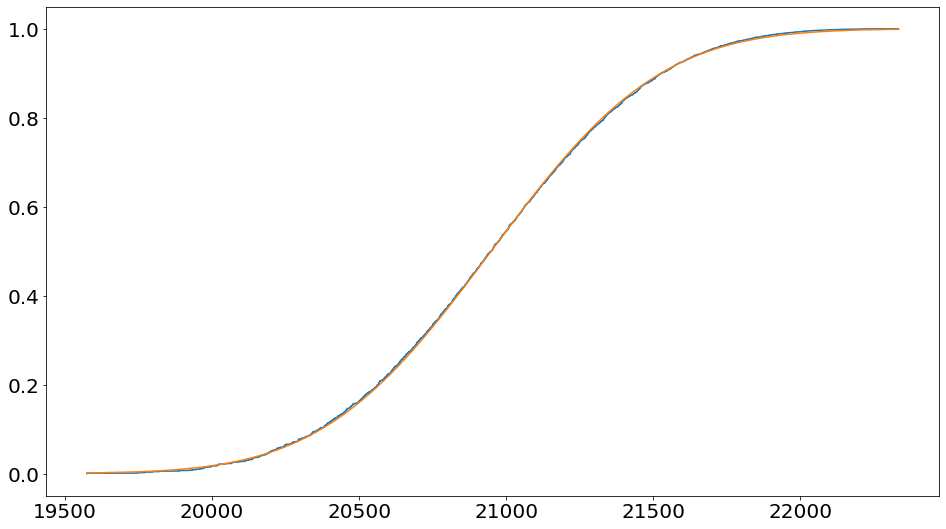

In [135]:
# x = np.linspace(np.amin(vv), np.amax(vv), 1000)
x = np.sort(vv)
plt.plot(x, np.linspace(0,1,(len(x))))
plt.plot(x, erf(x, mu+c+30, 1.05*var))
# plt.plot(x, np.linspace(0,1,(len(x))) - erf(x, mu+c+30, 1.05*var))

### Timings
Now [Fast] is about 5x faster than [Slow]. There may be a slight difference in accuracy, but I personally don't think it matters all that much.

In [21]:
%timeit qh.eval_arti(sub1)

106 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
%timeit qh.eval_arti(sub1, fast=False)

530 µs ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Querying "completeness" of artifact set (Contribution 3)
We can design another query type that gives the expected amount of time it would take to improve upon your current set's total DPS. 

For each slot (flower, feather, etc.) and main stat (ATK%, EM, HP%, etc.) we can compute the probability that a random new artifact, once upgraded to max, will improve upon the current set's total DPS. Then we can take the weighted average of these probabilities to be the total probability that a new artifact will improve the set's DPS. The expected time we would need to farm to improve DPS is then the inverse of the probability.

In [23]:
slotprobs = []
for i in range(5):
    slotprobs.append(qh.eval_slot(i))
    print(f'{slotnames[i]:7s}-  {slotprobs[-1]}')

Flower -  0.03959592347242475
Feath  -  0.27918481352149277
Sands  -  0.03997074931008088
Cup    -  0.024652017068497907
Hat    -  0.0006920061380296522


In [24]:
%timeit [qh.eval_slot(i) for i in range(5)]

296 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Evaluating/Testing
The function `QueryHandle::eval_slot` returns an estimate of the probability that a random new flower/feather/etc. will beat the current set's total damage value. We can compare the above predictions to estimates of the actual probability by creating many random artifacts below, using a Monte-Carlo approach.

In [25]:
def mc_slotprob(slot, N=1000):
    stats = diona_stats + sum([a for i, a in enumerate(artis) if i != slot])
    dmg0 = dmg.eval(stats + artis[slot])[0]
    
    num_exc = 0
    for _ in range(N):
        a = artifact2.make_arti(slot=slot).tostat()
        dmg2 = dmg.eval(stats + a)[0]
        if dmg2 > dmg0:
            num_exc += 1
    return num_exc / N

In [26]:
# slotprobs = []
for i in range(5):
    print(f'{slotnames[i]:7s}-  actual: {mc_slotprob(i, N=10000):.04f}\tapprox: {slotprobs[i]:.04f}')

Flower -  actual: 0.0484	approx: 0.0396
Feath  -  actual: 0.2881	approx: 0.2792
Sands  -  actual: 0.0479	approx: 0.0400
Cup    -  actual: 0.0256	approx: 0.0247
Hat    -  actual: 0.0009	approx: 0.0007


In [27]:
print(f'Expected farm duration for improvement: {5/sum(slotprobs)}')

Expected farm duration for improvement: 13.017595562030326


## Expected damage increase & dmg/resin
To wrap everything up, we can even estimate the expected damage increase per artifact farmed. Define the damage per artifact ratio as:
$$ \omega = \frac{\Delta D}{N} $$

where $\Delta D$ is the increase in damage, and $N$ is the number of artifacts farmed and upgraded before finding one that increases total damage.

In [28]:
qh.dmg_per_arti()

102.09499038180766

In [33]:
def mc_dpa_prob(N=1000):
    stats = diona_stats + sum([a for i, a in enumerate(artis)])
    dmg0 = dmg.eval(stats)[0]
    
    vs = []
    for _ in range(N):
        n = 0
        while True:
            n += 1
            a = artifact2.make_arti()
            dmg2 = dmg.eval(stats + a.tostat() - artis[a.slot])[0]
            if dmg2 > dmg0: break
        vs.append((dmg2 - dmg0) / n)
    print(np.mean(vs), np.std(vs))
    return vs

In [34]:
_ = mc_dpa_prob()

120.50532793428289 204.43195502587247


(array([426., 182., 100.,  71.,  48.,  32.,  21.,  13.,  14.,  11.,  10.,
          9.,   7.,   5.,   6.,   7.,   4.,   2.,   1.,   7.,   3.,   1.,
          4.,   1.,   1.,   0.,   1.,   1.,   2.,   0.,   2.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([7.56808933e-02, 3.64998020e+01, 7.29239230e+01, 1.09348044e+02,
        1.45772165e+02, 1.82196286e+02, 2.18620407e+02, 2.55044528e+02,
        2.91468649e+02, 3.27892771e+02, 3.64316892e+02, 4.00741013e+02,
        4.37165134e+02, 4.73589255e+02, 5.10013376e+02, 5.46437497e+02,
        5.82861618e+02, 6.19285739e+02, 6.55709860e+02, 6.92133981e+02,
        7.28558102e+02, 7.64982223e+02, 8.01406344e+02, 8.37830466e+02,
        8.74254587e+02, 9.10678708e+02, 9.47102829e+02, 9.83526950e+02,
        1.01995107e+03, 1.05637519e+03, 1.09279931e+03, 1.12922343e+03,
        1.16564756e+03, 1.20207168e+03, 1.23849580e+03, 1.27491992e+03,
        1.

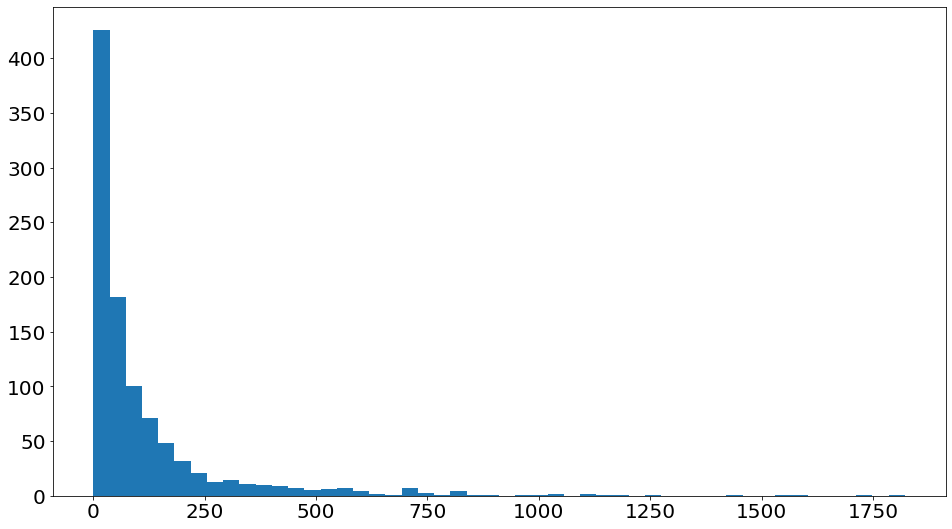

In [38]:
plt.hist(_, bins=50)